In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import numpy as np
from skimage.transform import resize
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import os

In [43]:
perform_computation = True

if os.path.exists('data/mnist.npz'):
    npzfile = np.load('data/mnist.npz')
    train_images_raw = npzfile['train_images_raw']
    train_labels = npzfile['train_labels']
    eval_images_raw = npzfile['eval_images_raw']
    eval_labels = npzfile['eval_labels']
else:
    import torchvision
    download_ = not os.path.exists('data/mnist.npz')
    data_train = torchvision.datasets.MNIST('mnist', train=True, transform=None, target_transform=None, download=download_)
    data_eval = torchvision.datasets.MNIST('mnist', train=False, transform=None, target_transform=None, download=download_)

    train_images_raw = data_train.data.numpy()
    train_labels = data_train.targets.numpy()
    eval_images_raw = data_eval.data.numpy()
    eval_labels = data_eval.targets.numpy()

    np.savez('data/mnist.npz', train_images_raw=train_images_raw, train_labels=train_labels,
             eval_images_raw=eval_images_raw, eval_labels=eval_labels)

(60000, 28, 28)
uint8
(60000,) int64
[5 0 4 1 9 2 1 3 1 4]
0 255
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 159, 253, 159, 50, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 238, 252, 252, 252, 237, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 227, 253, 252, 239, 233, 252, 57, 6, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 60, 224, 252, 253, 252, 202, 84, 252, 253, 122, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 252, 252, 252, 253, 252, 252, 96, 189, 253, 167, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 238, 253, 253, 190, 114, 253, 228, 47, 79, 255, 168, 0, 0, 0, 

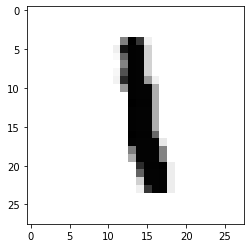

In [3]:
print(train_images_raw.shape)
print(train_images_raw.dtype)
print(train_labels.shape, train_labels.dtype)
print(train_labels[:10])
print(train_images_raw[0].min(), train_images_raw[0].max())

def show(image_raw):
    for row_im in image_raw:
        print(row_im.tolist())
show(train_images_raw[1])
plt.imshow(train_images_raw[6], cmap='Greys')

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, False, False, False, False, False, False, False, False]
[False, False, False

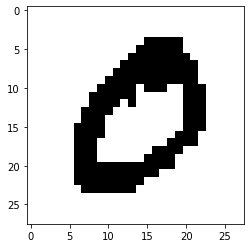

In [4]:
def get_thresholded(images_raw, threshold):
    """
    Perform image thresholding.

        Parameters:
                images_raw (np,array): Do not assume anything about its shape, dtype or range of values.
                Your function should be careless about these attributes.
                threshold (int): A scalar value.

        Returns:
                threshed_image (np.array): A numpy array with the same shape as images_raw, and the bool dtype.
                This array should indicate whether each elemelent of images_raw is greater than or equal to
                threshold.
    """

    # your code here
    threshed_image = images_raw >= threshold

    return threshed_image

ti = get_thresholded(train_images_raw[1], 20)
show(ti)
plt.imshow(ti, cmap='Greys')
allti = get_thresholded(train_images_raw, 20)
plt.imshow(allti[1], cmap='Greys')

In [5]:
def get_is_row_inky(images):
    """
    Finds the rows with ink pixels.

        Parameters:
                images (np,array): A numpy array with the shape (N, height, width)

        Returns:
                is_row_inky (np.array): A numpy array with the shape (N, height), and the bool dtype.
    """

    # your code here
    is_row_inky = np.any(images, axis=2)

    return is_row_inky

iri = get_is_row_inky(train_images_raw)
print(iri[1])

[False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False]


In [6]:
def get_is_col_inky(images):
    """
    Finds the columns with ink pixels.

        Parameters:
                images (np.array): A numpy array with the shape (N,height,width).

        Returns:
                is_col_inky (np.array): A numpy array with the shape (N, width), and the bool dtype.
    """

    # your code here
    is_col_inky = np.any(images, axis=1)

    return is_col_inky

a = get_is_col_inky(train_images_raw)
print(a[1])

[False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False False False]


In [7]:
def get_first_ink_row_index(is_row_inky):
    """
     Finds the first row containing ink pixels

        Parameters:
                is_row_inky (np.array): A numpy array with the shape (N, height), and the bool dtype.
                This is the output of the get_is_row_inky function that you implemented before.

        Returns:
                first_ink_rows (np.array): A numpy array with the shape (N,), and the int64 dtype.
    """

    # your code here
    #m = np.any(is_row_inky, axis=2)
    first_ink_rows = is_row_inky.argmax(axis=1)

    return first_ink_rows

r = get_first_ink_row_index(iri)
print(r)

[5 4 5 ... 5 2 6]


In [8]:
z = np.array([[0, 1, 0, 1], [1, 0, 0, 1], [0, 0, 1, 1]])
print(z.argmax(axis=1))
zr = z[:,::-1]
print(zr)
print(zr.shape)
print(zr.shape[1] - zr.argmax(axis=1) -1)

[1 0 2]
[[1 0 1 0]
 [1 0 0 1]
 [1 1 0 0]]
(3, 4)
[3 3 3]


In [9]:
def get_last_ink_row_index(is_row_inky):
    """
    Finds the last row containing ink pixels.

        Parameters:
                is_row_inky (np.array): A numpy array with the shape (N, height), and the bool dtype.
                This is the output of the get_is_row_inky function that you implemented before.

        Returns:
                last_ink_rows (np.array): A numpy array with the shape (N,), and the int64 dtype.
    """

    # your code here
    reversed_rows = is_row_inky[:,::-1]
    d = reversed_rows.shape[1]
    last_ink_rows = d - reversed_rows.argmax(axis=1) -1

    return last_ink_rows

r = get_last_ink_row_index(iri)
print(r)

[24 23 24 ... 24 21 24]


In [10]:
array = np.arange(12).reshape(3, 4)
print("Original array : \n", array)

# Rolling array; Shifting one place
print("\nRolling with 1 shift : \n", np.roll(array, 1))
print("\nRolling columns with 1 shift : \n", np.roll(array, 1, axis=1))
print("\nRolling rows with 1 shift : \n", np.roll(array, 1, axis=0))

array2 = np.arange(18).reshape(3, 3, 2)
print(array2)
#print("\nRolling rows with 1,0,2 shift : \n", np.roll(array2, [[-1], [-1]], axis=1))
def my_func(a):
    print(a)
    return 1
    #return np.roll(a, 1, axis=0)

#print(np.apply_along_axis(my_func, 0, array2))
#print(np.apply_along_axis(my_func, 1, array2))
def sf(im, sh):
    imr = np.roll(im, sh[0], axis=0)
    return np.roll(imr, sh[1], axis=1)
shift = [[-1,1],[2,1], [0,1]]
for (im, sh) in zip(array2, shift):
    print(sf(im, sh))

Original array : 
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]

Rolling with 1 shift : 
 [[11  0  1  2]
 [ 3  4  5  6]
 [ 7  8  9 10]]

Rolling columns with 1 shift : 
 [[ 3  0  1  2]
 [ 7  4  5  6]
 [11  8  9 10]]

Rolling rows with 1 shift : 
 [[ 8  9 10 11]
 [ 0  1  2  3]
 [ 4  5  6  7]]
[[[ 0  1]
  [ 2  3]
  [ 4  5]]

 [[ 6  7]
  [ 8  9]
  [10 11]]

 [[12 13]
  [14 15]
  [16 17]]]
[[3 2]
 [5 4]
 [1 0]]
[[ 9  8]
 [11 10]
 [ 7  6]]
[[13 12]
 [15 14]
 [17 16]]


In [11]:
def get_first_ink_col_index(is_col_inky):
    return get_first_ink_row_index(is_col_inky)

def get_last_ink_col_index(is_col_inky):
    return get_last_ink_row_index(is_col_inky)

<class 'numpy.uint8'>
[[15 14 15 ... 15 12 15]
 [14 14 13 ... 15 15 16]]
[[10]
 [10]]
(2, 60000)
<class 'numpy.uint8'>


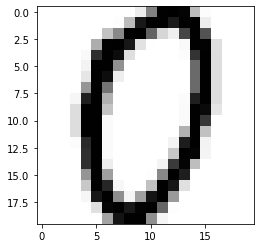

In [12]:

def get_images_bb(images, bb_size=20):
    """
    Applies the "Bounding Box" pre-processing step to images.

        Parameters:
                images (np.array): A numpy array with the shape (N,height,width)

        Returns:
                images_bb (np.array): A numpy array with the shape (N,bb_size,bb_size),
                and the same dtype as images.
    """

    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll add a dummy dimension to be consistent
        images_ = images.reshape(1,*images.shape)
    else:
        # Otherwise, we'll just work with what's given
        images_ = images

    print(type(images_[0,0, 0]))
    is_row_inky = get_is_row_inky(images_)
    is_col_inky = get_is_col_inky(images_)

    first_ink_rows = get_first_ink_row_index(is_row_inky)
    last_ink_rows = get_last_ink_row_index(is_row_inky)
    first_ink_cols = get_first_ink_col_index(is_col_inky)
    last_ink_cols = get_last_ink_col_index(is_col_inky)

    # your code here
    N = images_.shape[0]
    images_bb = np.zeros((N, bb_size, bb_size), dtype=np.uint8)
    rm = (first_ink_rows+last_ink_rows+1) // 2
    cm = (first_ink_cols+last_ink_cols+1) // 2
    rc_m = np.vstack([rm, cm])
    print(rc_m)
    rc_out = np.floor(np.array([[bb_size // 2], [bb_size // 2]])).astype(np.int)
    rc_rolls = (rc_out - rc_m)
    #if len(images.shape)==2:
    #    rc_rolls = rc_rolls.reshape(1, -1)
    print(rc_out)
    print(rc_rolls.shape)

    #for (image, roll) in zip(images_, rc_rolls):
    for i in range(N):
        image = images_[i]
        roll = rc_rolls[:,i]
        imr = np.roll(image, roll[0], axis=0)
        imr = np.roll(imr, roll[1], axis=1)
        images_bb[i] = imr[:bb_size,:bb_size]
        #plt.imshow(images_bb[i], cmap='Greys')

    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll get rid of the dummy dimension
        return images_bb[0]
    else:
        # Otherwise, we'll just work with what's given
        return images_bb
    
bb = get_images_bb(train_images_raw)
print(type(bb[0,0, 0]))
if len(bb.shape)==2:
    plt.imshow(bb, cmap='Greys')
else:
    plt.imshow(bb[1000], cmap='Greys')
#show(train_images_raw[1])
#print(bb)

14


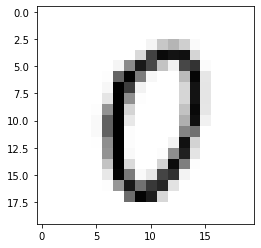

In [13]:
im = train_images_raw[1000]
plt.imshow(im, cmap='Greys')
print(im.shape[0] // 2)
image_resized = resize(im, (20, 20), preserve_range=True)
plt.imshow(image_resized, cmap='Greys')

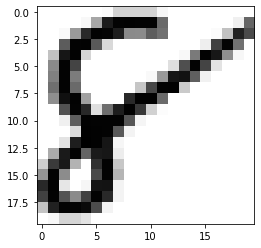

In [14]:
#Stretched bounding box: Construct a 20 x 20 bounding box so that the horizontal
# (resp. vertical) range of ink pixels runs the full horizontal (resp. vertical) range of the box.
# Obtaining this representation will involve rescaling image pixels:
# you find the horizontal and vertical ink range,
# cut that out of the original image,
# then resize the result to 20 x 20. Once the image has been re-centered, you can compute features.

def get_images_sbb(images, bb_size=20):
    """
    Applies the "Stretched Bounding Box" pre-processing step to images.

        Parameters:
                images (np.array): A numpy array with the shape (N,height,width)

        Returns:
                images_sbb (np.array): A numpy array with the shape (N,bb_size,bb_size),
                and the same dtype and the range of values as images.
    """

    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll add a dummy dimension to be consistent
        images_ = images.reshape(1,*images.shape)
    else:
        # Otherwise, we'll just work with what's given
        images_ = images

    is_row_inky = get_is_row_inky(images_)
    is_col_inky = get_is_col_inky(images_)

    first_ink_rows = get_first_ink_row_index(is_row_inky)
    last_ink_rows = get_last_ink_row_index(is_row_inky)
    first_ink_cols = get_first_ink_col_index(is_col_inky)
    last_ink_cols = get_last_ink_col_index(is_col_inky)

    # your code here
    N, h, w = images_.shape
    images_sbb = np.zeros((N, bb_size, bb_size), dtype=np.uint8)

    for i in range(N):
        image = images_[i]
        fir, lir = first_ink_rows[i], last_ink_rows[i]+1
        fic, lic = first_ink_cols[i], last_ink_cols[i]+1
        im_cut = image[fir:lir, fic:lic]
        #print(im_cut.shape)
        images_sbb[i] = resize(im_cut, (bb_size, bb_size), preserve_range=True)
        #images_sbb[i] = im_cut
        #plt.imshow(images_sbb[i], cmap='Greys')


    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll get rid of the dummy dimension
        return images_sbb[0]
    else:
        # Otherwise, we'll just work with what's given
        return images_sbb


sbb = get_images_sbb(train_images_raw)     # 615 19
if len(sbb.shape)==2:
    plt.imshow(sbb, cmap='Greys')
else:
    plt.imshow(sbb[615], cmap='Greys')

In [15]:
a1 = np.arange(48).reshape(3, 4, 4)
cuts = np.array([[0, 2],[1, 3],[0, 3]], dtype=np.uint8)
a1[2, 0, 0] = -1
print(a1)
print(cuts)
print(cuts[0, 0])
# TODO how to cut the 3d matrix based on indexes stored in another array
#print(a1[0, cuts[0]: cuts[0]])
N, h, w = a1.shape

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]

 [[-1 33 34 35]
  [36 37 38 39]
  [40 41 42 43]
  [44 45 46 47]]]
[[0 2]
 [1 3]
 [0 3]]
0


[    4    15    19 ... 59953 59973 59988]


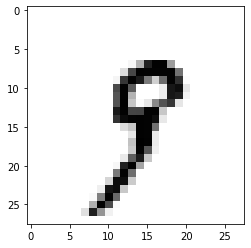

In [16]:
### Looking for images that extend to the last pixel in the columns
print(np.unique(np.argwhere(train_images_raw[:, 26, :] >= 20)[:,0]))
plt.imshow(train_images_raw[19], cmap='Greys')

In [36]:
train_images_threshed = get_thresholded(train_images_raw, threshold=20)
eval_images_threshed = get_thresholded(eval_images_raw, threshold=20)

train_images_bb = get_images_bb(train_images_threshed)
eval_images_bb = get_images_bb(eval_images_threshed)

if perform_computation:
    print('This is gonna take a while to finish...')
    #%time
    train_images_sbb = get_images_sbb(train_images_threshed)
    #%time
    eval_images_sbb = get_images_sbb(eval_images_threshed)
    print("Done")

<class 'numpy.bool_'>
[[15 14 15 ... 15 12 15]
 [14 14 13 ... 15 15 16]]
[[10]
 [10]]
(2, 60000)
<class 'numpy.bool_'>
[[17 13 14 ... 16 16 12]
 [14 17 15 ... 15 17 15]]
[[10]
 [10]]
(2, 10000)
This is gonna take a while to finish...
Done


In [50]:
def train_nb_eval_acc(train_images, train_labels, eval_images, eval_labels, density_model='Gaussian'):
    """
    Trains Naive Bayes models, apply the model, and return an accuracy.

        Parameters:
                train_images (np.array): A numpy array with the shape (N,height,width)
                train_labels (np.array): A numpy array with the shape (N,), where N is the number of samples and
                has the int64 dtype.
                eval_images (np.array): The evaluation images with similar characteristics to train_images.
                eval_labels (np.array): The evaluation labels with similar characteristics to train_labels.
                density_model (string): A string that is either 'Gaussian' or 'Bernoulli'.

        Returns:
                eval_acc (np.float): a floating number scalar between 0 and 1 that
                represents the accuracy of the trained model on the evaluation data.
    """

    assert density_model in ('Gaussian', 'Bernoulli')

    # your code here
    if density_model is 'Gaussian':
        model = GaussianNB()
    else:
        model = BernoulliNB()
    Nt = train_images.shape[0]
    Ne = eval_images.shape[0]
    # Vectorized all the features matrix, each pixel is a feature
    # In other words the train ser has 28 x 28 = 748 features
    train_images_ = train_images.reshape(Nt, -1)
    eval_images_ = eval_images.reshape(Ne, -1)
    model.fit(train_images_, train_labels)
    pred_labels = model.predict(eval_images_)
    positives = (eval_labels == pred_labels).sum()
    eval_acc = positives / Ne

    return eval_acc

acc_nbg_thr = train_nb_eval_acc(train_images_threshed, train_labels,
                                eval_images_threshed, eval_labels, density_model='Gaussian')
acc_nbb_thr = train_nb_eval_acc(train_images_threshed, train_labels,
                                eval_images_threshed, eval_labels, density_model='Bernoulli')
acc_nbg_sbb = train_nb_eval_acc(train_images_sbb, train_labels,
                                eval_images_sbb, eval_labels, density_model='Gaussian')
acc_nbb_sbb = train_nb_eval_acc(train_images_sbb, train_labels,
                                eval_images_sbb, eval_labels, density_model='Bernoulli')

df = pd.DataFrame([('Untouched images', acc_nbg_thr, acc_nbb_thr),
                   ('Stretched bounding box', acc_nbg_sbb, acc_nbb_sbb)
                  ], columns = ['Accuracy' , 'Gaussian', 'Bernoulli'])

df

,Accuracy,Gaussian,Bernoulli
0,Untouched images,0.5491,0.843
1,Stretched bounding box,0.8030,0.809


In [45]:
def train_tree_eval_acc(train_images, train_labels, eval_images, eval_labels, tree_num=10, tree_depth=4, random_state=12345):
    """
    Trains Naive Bayes models, apply the model, and return an accuracy.

        Parameters:
                train_images (np.array): A numpy array with the shape (N,height,width)
                train_labels (np.array): A numpy array with the shape (N,), where N is the number of samples and
                has the int64 dtype.
                eval_images (np.array): The evaluation images with similar characteristics to train_images.
                eval_labels (np.array): The evaluation labels with similar characteristics to train_labels.
                tree_num (int): An integer number representing the number of trees in the decision forest.
                tree_depth (int): An integer number representing the maximum tree depth in the decision forest.
                random_state (int): An integer with a default value of 12345 that should be passed to
                the scikit-learn's classifer constructor for reproducibility and auto-grading

        Returns:
                eval_acc (np.float): a floating number scalar between 0 and 1 that
                represents the accuracy of the trained model on the evaluation data.
    """

    tree_num = int(tree_num)
    tree_depth = int(tree_depth)
    random_state = int(random_state)

    # your code here
    model = RandomForestClassifier(n_estimators=tree_num, max_depth=tree_depth, random_state=random_state)
    Nt = train_images.shape[0]
    Ne = eval_images.shape[0]
    # Vectorized all the features matrix, each pixel is a feature
    # In other words the train ser has 28 x 28 = 748 features
    train_images_ = train_images.reshape(Nt, -1)
    eval_images_ = eval_images.reshape(Ne, -1)
    model.fit(train_images_, train_labels)
    pred_labels = model.predict(eval_images_)
    positives = (eval_labels == pred_labels).sum()
    eval_acc = positives / Ne

    return eval_acc


In [46]:
# 2.1 Accuracy on the Untouched Images

df = None
if perform_computation:
    print('This is gonna take a while to finish...')
    tree_nums = [10, 20, 30]
    tree_depths = [4, 8, 16]

    train_images = train_images_threshed
    eval_images = eval_images_threshed
    acc_arr_unt = np.zeros((len(tree_nums), len(tree_depths)))
    for row, tree_num in enumerate(tree_nums):
        for col, tree_depth in enumerate(tree_depths):
            acc_arr_unt[row, col] = train_tree_eval_acc(train_images, train_labels, eval_images, eval_labels,
                                                        tree_num=tree_num, tree_depth=tree_depth, random_state=12345)

    df = pd.DataFrame([(f'#trees = {tree_num}', *tuple(acc_arr_unt[row])) for row, tree_num in enumerate(tree_nums)],
                      columns = ['Accuracy'] + [f'depth={tree_depth}'for col, tree_depth in enumerate(tree_depths)])

    print('Untouched Images:')
df

Untouched Images:
      Accuracy  depth=4  depth=8  depth=16
0  #trees = 10   0.7496   0.8923    0.9489
1  #trees = 20   0.7707   0.9127    0.9585
2  #trees = 30   0.7883   0.9169    0.9630


In [47]:
# 2.2 Accuracy on the "Stretched Bounding Box" Images

df = None
if perform_computation:
    print('This is gonna take a while to finish...')
    tree_nums = [10, 20, 30]
    tree_depths = [4, 8, 16]

    train_images = train_images_sbb
    eval_images = eval_images_sbb
    acc_arr_sbb = np.zeros((len(tree_nums), len(tree_depths)))
    for row, tree_num in enumerate(tree_nums):
        for col, tree_depth in enumerate(tree_depths):
            acc_arr_sbb[row, col] = train_tree_eval_acc(train_images, train_labels, eval_images, eval_labels,
                                                        tree_num=tree_num, tree_depth=tree_depth, random_state=12345)

    df = pd.DataFrame([(f'#trees = {tree_num}', *tuple(acc_arr_sbb[row])) for row, tree_num in enumerate(tree_nums)],
                      columns = ['Accuracy'] + [f'depth = {tree_depth}'for col, tree_depth in enumerate(tree_depths)])

    print('Stretched Bounding Box Images:')
df

This is gonna take a while to finish...
Stretched Bounding Box Images:


,Accuracy,depth = 4,depth = 8,depth = 16
0,#trees = 10,0.6935,0.8657,0.9341
1,#trees = 20,0.7202,0.8831,0.9472
2,#trees = 30,0.7341,0.8863,0.9507


In [48]:
# 2.3 Accuracy on the "Bounding Box" Images

df = None
if perform_computation:
    print('This is gonna take a while to finish...')
    tree_nums = [10, 20, 30]
    tree_depths = [4, 8, 16]

    train_images = train_images_bb
    eval_images = eval_images_bb
    acc_arr_bb = np.zeros((len(tree_nums), len(tree_depths)))
    for row, tree_num in enumerate(tree_nums):
        for col, tree_depth in enumerate(tree_depths):
            acc_arr_bb[row, col] = train_tree_eval_acc(train_images, train_labels, eval_images, eval_labels,
                                                       tree_num=tree_num, tree_depth=tree_depth, random_state=12345)

    df = pd.DataFrame([(f'#trees = {tree_num}', *tuple(acc_arr_bb[row])) for row, tree_num in enumerate(tree_nums)],
                      columns = ['Accuracy'] + [f'depth = {tree_depth}'for col, tree_depth in enumerate(tree_depths)])

    print('Bounding Box Images:')
df

This is gonna take a while to finish...
Bounding Box Images:


,Accuracy,depth = 4,depth = 8,depth = 16
0,#trees = 10,0.7406,0.8865,0.9476
1,#trees = 20,0.7716,0.9050,0.9576
2,#trees = 30,0.7801,0.9089,0.9608
